In [1]:
import torch.nn as nn
import torch
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# from model import SoundExtractor, SoundClassifier
from models import *
from fighting_dataset import *
from utility import *

In [20]:
x_train, y_train, x_val, y_val, x_test, y_test, sampling_rate, train_type = load_fighting_dataset_without_matlab(hop_legnth=20, data_aug=False, useless_data=[])

# 레이블별 사운드 분류

In [23]:
def segment_sound_gyeore(sound, label, sampling_rate, hop_length):
    # hop_length = hop_length 
    window_size = int(hop_length * 2)
    result_data = np.zeros((100, window_size))
    result_label = []
    total_count = 0
    less_length = 0
    
    for i, y in enumerate(sound):
        # y = center_crop(y, label[i], sampling_rate*20, len(y)//2)
        if label[i] == 'crowd':
            y = center_crop(y, len(y)//4)
        elif label[i] == 'epic':
            y = center_crop(y, len(y)//4)
        if len(y) < window_size:
            less_length += 1
            print("sound length is less than 40 ms", less_length)
            continue
        
        D = np.abs(librosa.stft(y, n_fft=window_size, win_length = window_size, hop_length=hop_length, center=False))
        mel_spec = librosa.feature.melspectrogram(S=D, sr=sampling_rate, n_mels=64, hop_length=hop_length, win_length=window_size)
        amplitude = librosa.amplitude_to_db(mel_spec, ref=1.0)
        o_env = librosa.onset.onset_strength(y=y, sr=sampling_rate, S=amplitude)   
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length)
        times = librosa.times_like(o_env, sr=sampling_rate, hop_length=hop_length)
        
        ipd.display(Audio(sound, rate=sampling_rate))
        fig, ax = plt.subplots(nrows=3, sharex=True)
        librosa.display.specshow(amplitude, x_axis='time', y_axis='log', ax=ax[0])
        ax[0].set(title='Power spectrogram')
        ax[0].label_outer()
        ax[1].plot(times, o_env, label='Onset strength')
        ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        ax[1].legend()
        ax[1].axis(xmin=0, xmax=len(y)/sampling_rate)
        ax[2].plot(np.linspace(0, len(y)/sampling_rate, len(y)), y)
        ax[2].vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        ax[2].legend(['signal', 'onsets'])
        plt.show()
        
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length, units='samples')
        for sample in onset_frames:
            if sample >= len(y) - window_size:
                print('continue')
                continue               
            result_data[total_count] = y[sample:sample+window_size]
            total_count += 1
            result_label += [label[i]]
    
    print("the number of total sound segment: %d"%(total_count))
    print("the number of sounds of which length is less than 40ms: %d"%(less_length))
    return result_data[:total_count], np.array(result_label)

In [ ]:
import IPython.display as ipd
from IPython.display import Audio

filepath = os.path.join('.', 'dataset', 'Fighting')
label_name = os.listdir(filepath)
for label in label_name:
    folder_name = os.listdir(os.path.join(filepath, label))
    for folder in folder_name:
        # if folder.lower() in useless_data:
        #     print("{}-{} not used".format(label, folder))
        #     continue
        file_name = os.listdir(os.path.join(filepath, label, folder))
        for sound_name in file_name:
            sound_file_path = os.path.join(filepath, label, folder, sound_name)
            print('label: {}, sound source: {}, file name: {}'.format(label, folder, sound_name))
            sound, sr = torchaudio.load(sound_file_path)
            sampling_rate = 44100
            if sound.shape[0] == 2:
                sound = torch.mean(sound, dim=0).view(1, -1) # 겨레형이 loudness 구할 때 평균내서 사용하였음.
            sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
            # sound = sound[0].numpy()
            hop_length = 882
            window_size = int(hop_length*2)        
            
            sound_list, _ = segment_sound_gyeore(sound, list(label), sampling_rate, hop_length=hop_length)

            for i in range(len(sound_list)):
                ipd.display(Audio(sound_list[i], rate=sampling_rate))
                print(sound_list[i].shape)
                D = np.abs(librosa.stft(sound_list[i], n_fft=window_size, win_length = window_size, hop_length=hop_length, center=True))
                S_db = librosa.amplitude_to_db(D, ref=1.0)
                
                fig, ax = plt.subplots()
                img = librosa.display.specshow(S_db, x_axis='ms', y_axis='linear', ax=ax, sr=sampling_rate)
                ax.set(title='Using a logarithmic frequency axis')
                fig.colorbar(img, ax=ax, format="%+2.f dB")
                plt.savefig('temp.png', dpi=300)
                plt.show()         
                
                _ = input()
            plt.clf()

## 랜덤한 사운드에 대한 spectogram

attack
crowd
epic
exciting
voice
whoosh
label: whoosh, sound source: Epidemic Sound, file name: ES_Bolas Spin - SFX Producer.wav


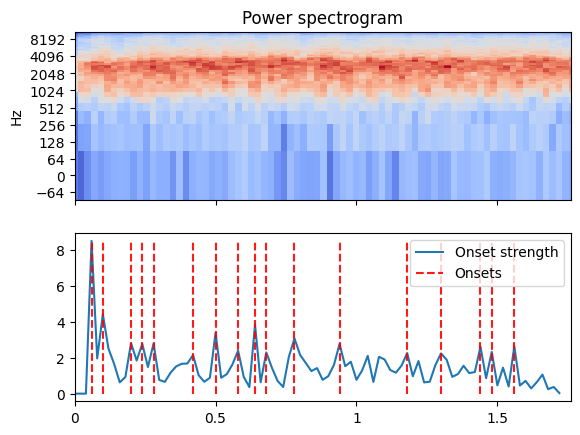

the number of total sound segment: 17
the number of sounds of which length is less than 40ms: 0


(1764,)


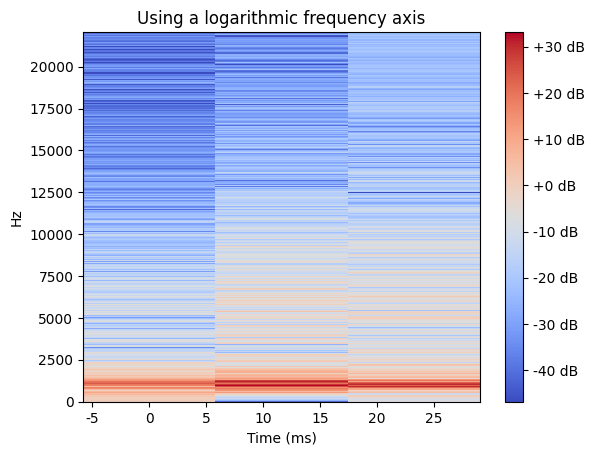

KeyboardInterrupt: Interrupted by user

In [11]:
import IPython.display as ipd
from IPython.display import Audio
import pandas as pd

filepath = os.path.join('.', 'dataset', 'Fighting')
label_name = os.listdir(filepath)

filepath_list = []
label_list = []
folder_list = []
sound_name_list = []

for label in label_name:
    print(label)
    folder_name = os.listdir(os.path.join(filepath, label))
    for folder in folder_name:
        # if folder.lower() in useless_data:
        #     print("{}-{} not used".format(label, folder))
        #     continue
        file_name = os.listdir(os.path.join(filepath, label, folder))
        for sound_name in file_name:
            sound_file_path = os.path.join(filepath, label, folder, sound_name)
            
            filepath_list.append(filepath)
            label_list.append(label)
            folder_list.append(folder)
            sound_name_list.append(sound_name)

shuffle_index = np.arange(len(filepath_list))
shuffle_index = np.arange(len(filepath_list))
np.random.shuffle(shuffle_index)

for i in shuffle_index:
    filepath = filepath_list[i]
    label = label_list[i]
    folder = folder_list[i]
    sound_name = sound_name_list[i]

    print('label: {}, sound source: {}, file name: {}'.format(label, folder, sound_name))
    sound_file_path = os.path.join(filepath, label, folder, sound_name)
    sound, sr = torchaudio.load(sound_file_path)
    sampling_rate = 44100
    if sound.shape[0] == 2:
        sound = torch.mean(sound, dim=0).view(1, -1)
    sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
    # sound = sound[0].numpy()
    hop_length = 882
    window_size = int(hop_length*2)        

    sound_list, _ = segment_sound_gyeore(sound, list(label), sampling_rate, hop_length=hop_length)

    for i in range(len(sound_list)):
        ipd.display(Audio(sound_list[i], rate=sampling_rate))
        print(sound_list[i].shape)
        D = np.abs(librosa.stft(sound_list[i], n_fft=window_size, win_length = window_size, hop_length=hop_length, center=True))
        S_db = librosa.amplitude_to_db(D, ref=1.0)
        # print('D shape : {}, S_db shape : {}'.format(D.shape, S_db.shape))
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(S_db, x_axis='ms', y_axis='linear', ax=ax, sr=44100)
        ax.set(title='Using a logarithmic frequency axis')
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        plt.savefig('temp.png', dpi=300)
        plt.show()         
        
        _ = input()

## 특정 사운드에 대한 onset detetion plotting

the number of onsets : [ 33  81 133]


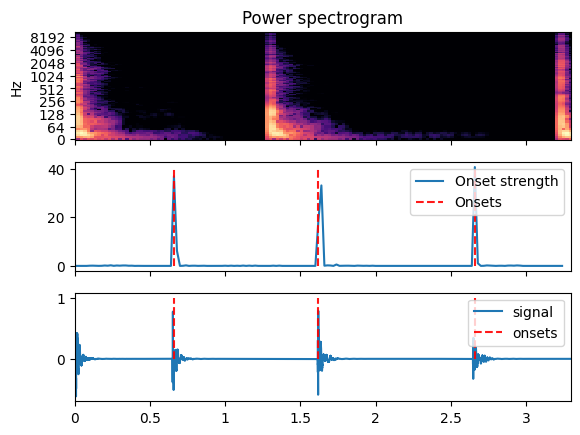

In [18]:
n_mels = 64
hop_length = 882
window_size = int(hop_length*2)
sampling_rate = 44100

filepath = os.path.join('dataset', 'Fighting', 'attack', 'Artlist', 'Céline Woodburn - Dissection - Punch, Body Thud, Multiple.wav')
sound, sr = torchaudio.load(filepath, normalize=True)
sampling_rate = 44100
if sound.shape[0] == 2:
    sound = torch.mean(sound, dim=0).view(1, -1)
sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
# sound = torch.mean(sound, dim=0).view(1, -1)
y = sound[0]

D = np.abs(librosa.stft(y, n_fft=window_size, win_length = window_size, hop_length=hop_length, center=False))
mel_spec = librosa.feature.melspectrogram(S=D, sr=sampling_rate, n_mels=n_mels, hop_length=hop_length, win_length=window_size)
amplitude = librosa.amplitude_to_db(mel_spec, ref=1.0)
o_env = librosa.onset.onset_strength(y=y, sr=sampling_rate, S=amplitude)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length)
print('the number of onsets : {}'.format(onset_frames))

times = librosa.times_like(o_env, sr=sampling_rate, hop_length=hop_length)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=3, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].legend()
ax[1].axis(xmin=0, xmax=len(y)/sampling_rate)
ax[2].plot(np.linspace(0, len(y)/sampling_rate, len(y)), y)
ax[2].vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[2].legend(['signal', 'onsets'])
# plt.show()
# plt.plot(np.linspace(0, len(y)/sampling_rate, len(y)), y)
# plt.vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
#            linestyle='--', label='Onsets')
# plt.legend(['signal', 'onsets'])
# plt.show()

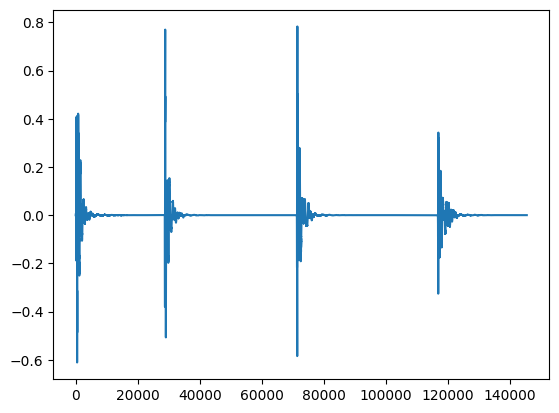

In [122]:
plt.plot(y)

## Energy와 onset detection 비교 

In [31]:
def segment_sound_energy(sound, label, sampling_rate, hop_length):
    # hop_length = hop_length 
    window_size = int(hop_length * 2)
    result_data = np.zeros((300, window_size))
    result_label = []
    total_count = 0
    less_length = 0
    
    for i, y in enumerate(sound):
        # y = center_crop(y, label[i], sampling_rate*20, len(y)//2)
        if label[i] == 'crowd':
            y = center_crop(y, len(y)//4)
        elif label[i] == 'epic':
            y = center_crop(y, len(y)//4)
        if len(y) < window_size:
            less_length += 1
            print("sound length is less than 40 ms", less_length)
            continue
        
        # Onset detection
        D = np.abs(librosa.stft(y, n_fft=window_size, win_length = window_size, hop_length=hop_length, center=False))
        mel_spec = librosa.feature.melspectrogram(S=D, sr=sampling_rate, n_mels=64, hop_length=hop_length, win_length=window_size)
        amplitude = librosa.amplitude_to_db(mel_spec, ref=1.0)
        o_env = librosa.onset.onset_strength(y=y, sr=sampling_rate, S=amplitude)   
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length)
        times = librosa.times_like(o_env, sr=sampling_rate, hop_length=hop_length)
        
        # Plot onset detection
        ipd.display(Audio(sound, rate=sampling_rate))
        fig, ax = plt.subplots(nrows=3, sharex=True)
        librosa.display.specshow(amplitude, x_axis='time', y_axis='log', ax=ax[0])
        ax[0].set(title='Power spectrogram')
        ax[0].label_outer()
        ax[1].plot(times, o_env, label='Onset strength')
        ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        ax[1].legend()
        ax[1].axis(xmin=0, xmax=len(y)/sampling_rate)
        ax[2].plot(np.linspace(0, len(y)/sampling_rate, len(y)), y)
        ax[2].vlines(times[onset_frames], 0, 1, color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        ax[2].legend(['signal', 'onsets'])
        plt.show()
        
        print('frames: ', onset_frames)
        print('times[onset_frames]: ', times[onset_frames])
        # onset detection으로 segmentation
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sampling_rate, hop_length=hop_length, units='samples')
        print('samples: ', onset_frames)
        for sample in onset_frames:
            if sample >= len(y) - window_size:
                print('continue')
                continue               
            result_data[total_count] = y[sample:sample+window_size]
            total_count += 1
            result_label += [label[i]]
            
        # energy 계산
        start_point = 0
        end_point = start_point + sampling_rate - 1
        energy_index = [[i, i+window_size] for i in range(start_point, end_point, hop_length) if i + window_size <= end_point]
        energy = [y[index[0]:index[1]] for index in energy_index]
        # print(energy.shape)
        print(energy_index) 
        print(len(energy), len(energy[0]))
        
        energy = np.concatenate(energy, axis=0)
        print(energy.shape)
    
    print("the number of total sound segment: %d"%(total_count))
    print("the number of sounds of which length is less than 40ms: %d"%(less_length))
    return result_data[:total_count], np.array(result_label)

attack
crowd
epic
exciting
voice
whoosh
label: whoosh, sound source: Freesound, file name: 611766__sam300productions__sword-swings.mp3
sound length is less than 40 ms 1
the number of total sound segment: 0
the number of sounds of which length is less than 40ms: 1
-------------------------------------------------------------------------------
label: attack, sound source: Hand-to-Hand_Combat, file name: Hand-to-Hand Combat - Body Hits - Body Slam Floor 02.wav


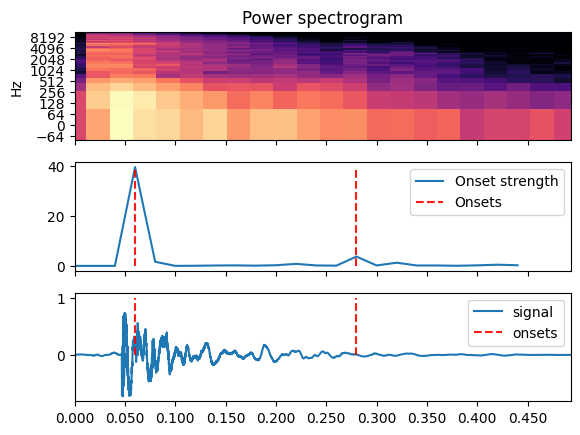

frames:  [ 3 14]
times[onset_frames]:  [0.06 0.28]
samples:  [ 2646 12348]
[[0, 1764], [882, 2646], [1764, 3528], [2646, 4410], [3528, 5292], [4410, 6174], [5292, 7056], [6174, 7938], [7056, 8820], [7938, 9702], [8820, 10584], [9702, 11466], [10584, 12348], [11466, 13230], [12348, 14112], [13230, 14994], [14112, 15876], [14994, 16758], [15876, 17640], [16758, 18522], [17640, 19404], [18522, 20286], [19404, 21168], [20286, 22050], [21168, 22932], [22050, 23814], [22932, 24696], [23814, 25578], [24696, 26460], [25578, 27342], [26460, 28224], [27342, 29106], [28224, 29988], [29106, 30870], [29988, 31752], [30870, 32634], [31752, 33516], [32634, 34398], [33516, 35280], [34398, 36162], [35280, 37044], [36162, 37926], [37044, 38808], [37926, 39690], [38808, 40572], [39690, 41454], [40572, 42336], [41454, 43218]]
48 1764
(42582,)
the number of total sound segment: 2
the number of sounds of which length is less than 40ms: 0


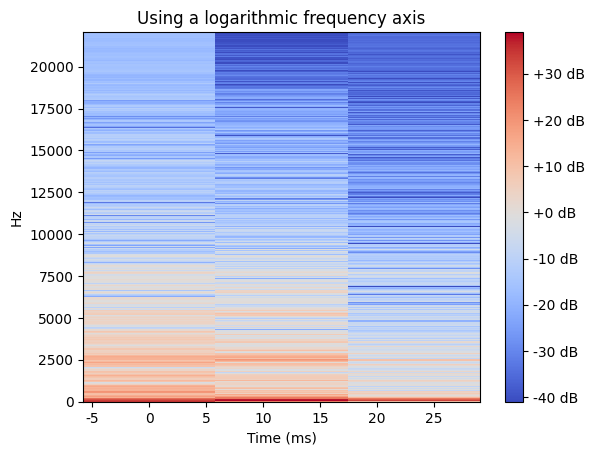

In [32]:
import IPython.display as ipd
from IPython.display import Audio
import pandas as pd

filepath = os.path.join('.', 'dataset', 'Fighting')
label_name = os.listdir(filepath)

filepath_list = []
label_list = []
folder_list = []
sound_name_list = []

for label in label_name:
    print(label)
    folder_name = os.listdir(os.path.join(filepath, label))
    for folder in folder_name:
        # if folder.lower() in useless_data:
        #     print("{}-{} not used".format(label, folder))
        #     continue
        file_name = os.listdir(os.path.join(filepath, label, folder))
        for sound_name in file_name:
            sound_file_path = os.path.join(filepath, label, folder, sound_name)
            
            filepath_list.append(filepath)
            label_list.append(label)
            folder_list.append(folder)
            sound_name_list.append(sound_name)

shuffle_index = np.arange(len(filepath_list))
shuffle_index = np.arange(len(filepath_list))
np.random.shuffle(shuffle_index)

for i in shuffle_index:
    filepath = filepath_list[i]
    label = label_list[i]
    folder = folder_list[i]
    sound_name = sound_name_list[i]

    print('label: {}, sound source: {}, file name: {}'.format(label, folder, sound_name))
    sound_file_path = os.path.join(filepath, label, folder, sound_name)
    sound, sr = torchaudio.load(sound_file_path)
    sampling_rate = 44100
    if sound.shape[0] == 2:
        sound = torch.mean(sound, dim=0).view(1, -1)
    sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate).numpy()
    # sound = sound[0].numpy()
    hop_length = 882
    window_size = int(hop_length*2)        

    sound_list, _ = segment_sound_energy(sound, list(label), sampling_rate, hop_length=hop_length)

    for i in range(len(sound_list)):
        ipd.display(Audio(sound_list[i], rate=sampling_rate))
        D = np.abs(librosa.stft(sound_list[i], n_fft=window_size, win_length = window_size, hop_length=hop_length, center=True))
        S_db = librosa.amplitude_to_db(D, ref=1.0)
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(S_db, x_axis='ms', y_axis='linear', ax=ax, sr=44100)
        ax.set(title='Using a logarithmic frequency axis')
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        plt.savefig('temp.png', dpi=300)
        plt.show()         
        
        _ = input()
    print('-------------------------------------------------------------------------------')

In [111]:
# attack, whoosh의 경우 전체에서 1개...? 
# 만약에 여러개 한다면 

NameError: name 'energy' is not defined